# Evaluation scripts

- [x] Plotting loss curves.
- [ ] Plotting RMSD and HDD curves.
- [ ] Generating CIFs.

### Scripts for plotting loss curves

In [1]:
import torch
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np

def get_metrics(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    metrics = checkpoint['metrics']
    fname = '/'.join(ckpt_path.split('/')[:-1])
    return metrics, fname

def plot_curves(paths, ylog=True, xlog=False, xmin=None, xmax=None, offset = 0.02, plot_metrics=True):
    if plot_metrics:
        fig, axes = plt.subplots(3,1,figsize=(10,5*1.5), dpi=150)
        ax_loss, ax_RMSD, ax_HDD = axes
    else:
        fig, axes = plt.subplots(figsize=(10,5), dpi=150)
        ax_loss = axes
        axes = [axes]

    text_positions = []
    
    ax_loss.set(xlabel='Epoch', ylabel='CE-Loss')
    if plot_metrics:
        ax_RMSD.set(xlabel='Epoch', ylabel='Mean RMSD')
        ax_HDD.set(xlabel='Epoch', ylabel='Mean Hausdorff distance')

    for ax in axes:
        if xmin is not None or xmax is not None:
            ax.set_xlim(xmin, xmax)
        if ylog:
            ax_loss.set_yscale('log')
        if xlog:
            ax_loss.set_xscale('log')
        ax.grid(alpha=0.2, which="both")

    for path in paths:
        metrics, fname = get_metrics(path)
        losses_train, losses_val, epochs = metrics['train_losses'], metrics['val_losses'], metrics['epoch_losses']
        RMSD_train, RMSD_val, RMSD_epochs = metrics['train_RMSD'], metrics['val_RMSD'], metrics['epoch_RMSD']
        HDD_train, HDD_val, HDD_epochs = metrics['train_HDD'], metrics['val_HDD'], metrics['epoch_HDD']
        
        # Losses
        p = ax_loss.plot(epochs, losses_train, label=fname + f' [{losses_val[-1].item():1.3f}]')
        ax_loss.plot(epochs, losses_val, c=p[0].get_color(), ls='--')
        
        if plot_metrics:
            # RMSD
            p = ax_RMSD.plot(RMSD_epochs, RMSD_train, label=fname)
            ax_RMSD.plot(RMSD_epochs, RMSD_val, c=p[0].get_color(), ls='--')
#             ax_RMSD.set_ylim(0,110)

            # HDD
            p = ax_HDD.plot(HDD_epochs, HDD_train, label=fname)
            ax_HDD.plot(HDD_epochs, HDD_val, c=p[0].get_color(), ls='--')
#             ax_HDD.set_ylim(0,110)
        
        # Find the minimum value in losses_val and its corresponding epoch
        try:
            val_line_min = epochs[np.argmin(losses_val)].item()
            min_loss_val = torch.min(losses_val).item()
        
            # Plot the dotted line
            ax_loss.plot([val_line_min, ax.get_xlim()[1]], [min_loss_val, min_loss_val],
                        c=p[0].get_color(), ls=':', alpha=1.0)

            # Adjust text position if overlapping
            text_x = ax.get_xlim()[1]
            text_y = min_loss_val
        
            vert_align = 'bottom'
            for pos in text_positions:
                if abs(pos[1] - text_y) < offset:  # Check for overlap
                    vert_align = 'top'
                else:
                    vert_align = 'bottom'

            # Add text at the end of the dotted line
            ax_loss.text(text_x, text_y, f'{min_loss_val:.4f}', 
                    verticalalignment=vert_align, horizontalalignment='right', color=p[0].get_color(),
                    fontsize=10)
            text_positions.append((text_x, text_y))
        except:
            pass
     
    for ax in axes:
        ax.legend(fontsize=8, ncol=4)
    fig.tight_layout()
    plt.show()

#### Loss curves

In [ ]:
plot_curves(
    [
        'debug_metrics/'
    ],
    ylog = True,
    xlog = False,
    plot_metrics = False,
)


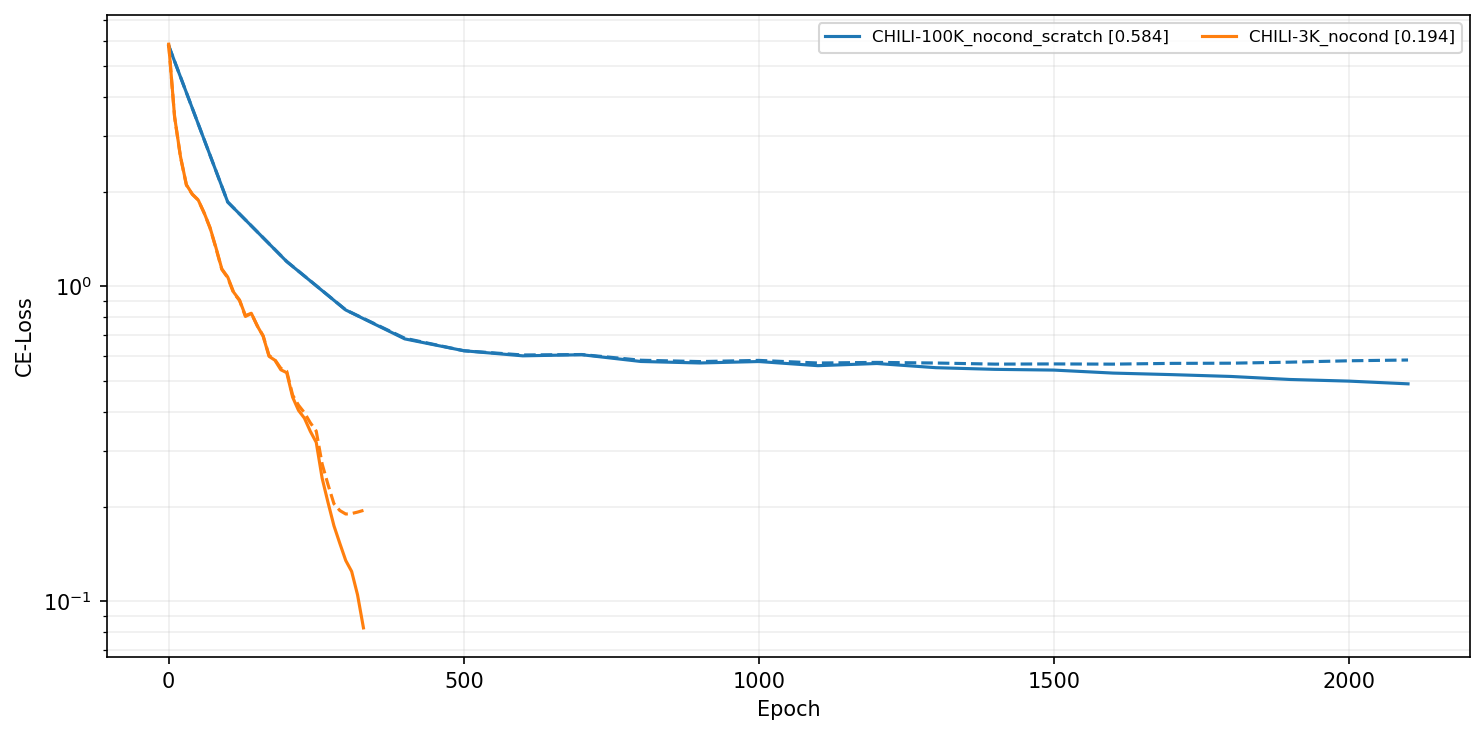

number of total parameters: 25.36M
------------------------------
RheniumTrioxide_CuO3
------------------------------
Generation no. 1 :
data_Cu1O3
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_atom_type_ionic_radius
Cu 1.9000 1.3500 0.8200
O 3.4400 0.6000 1.2600
_symmetry_space_group_name_H-M Pm-3m
_cell_length_a 3.8871
_cell_length_b 3.8871
_cell_length_c 3.8871
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 221
_chemical_formula_structural CuO3
_chemical_formula_sum 'Cu1 O3'
_cell_volume 58.8238
_cell_formula_units_Z 1
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1 'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Cu Cu0 1 0.0000 0.0000 0.0000 1.0
O O1 3 0.0000 0.5000 0.5000 1.0data_Ca16Al8Si8O44
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_at

In [25]:
plot_curves(
    [
        'CHILI-100K_nocond_scratch/ckpt.pt',
        'CHILI-3K_nocond/ckpt.pt'
    ],
    ylog = True,
    xlog = False,
    plot_metrics = False,
)

import torch
from bin.generate_samples import generate_samples, SampleDefaults, get_data
from crystallm import CIFTokenizer, GPT, GPTConfig
import os

config = SampleDefaults()

config.model_dir = 'CHILI-100K_nocond_scratch/'
config.dataset_dir = 'datasets/CHILI-3K_nocond/'
config.debug_max = 1
config.cond_window = 3000
config.split = 'train'
config.fit_xrd = False
config.top_k = None
config.device = 'cuda'

config.add_composition = True
config.add_spacegroup = True

config.n_repeats = 1

config.plot_xrd = False

# config.post_process = True
# config.out = "generation_out_test.tar.gz"
# config.individual_cifs = True

generate_samples(config)

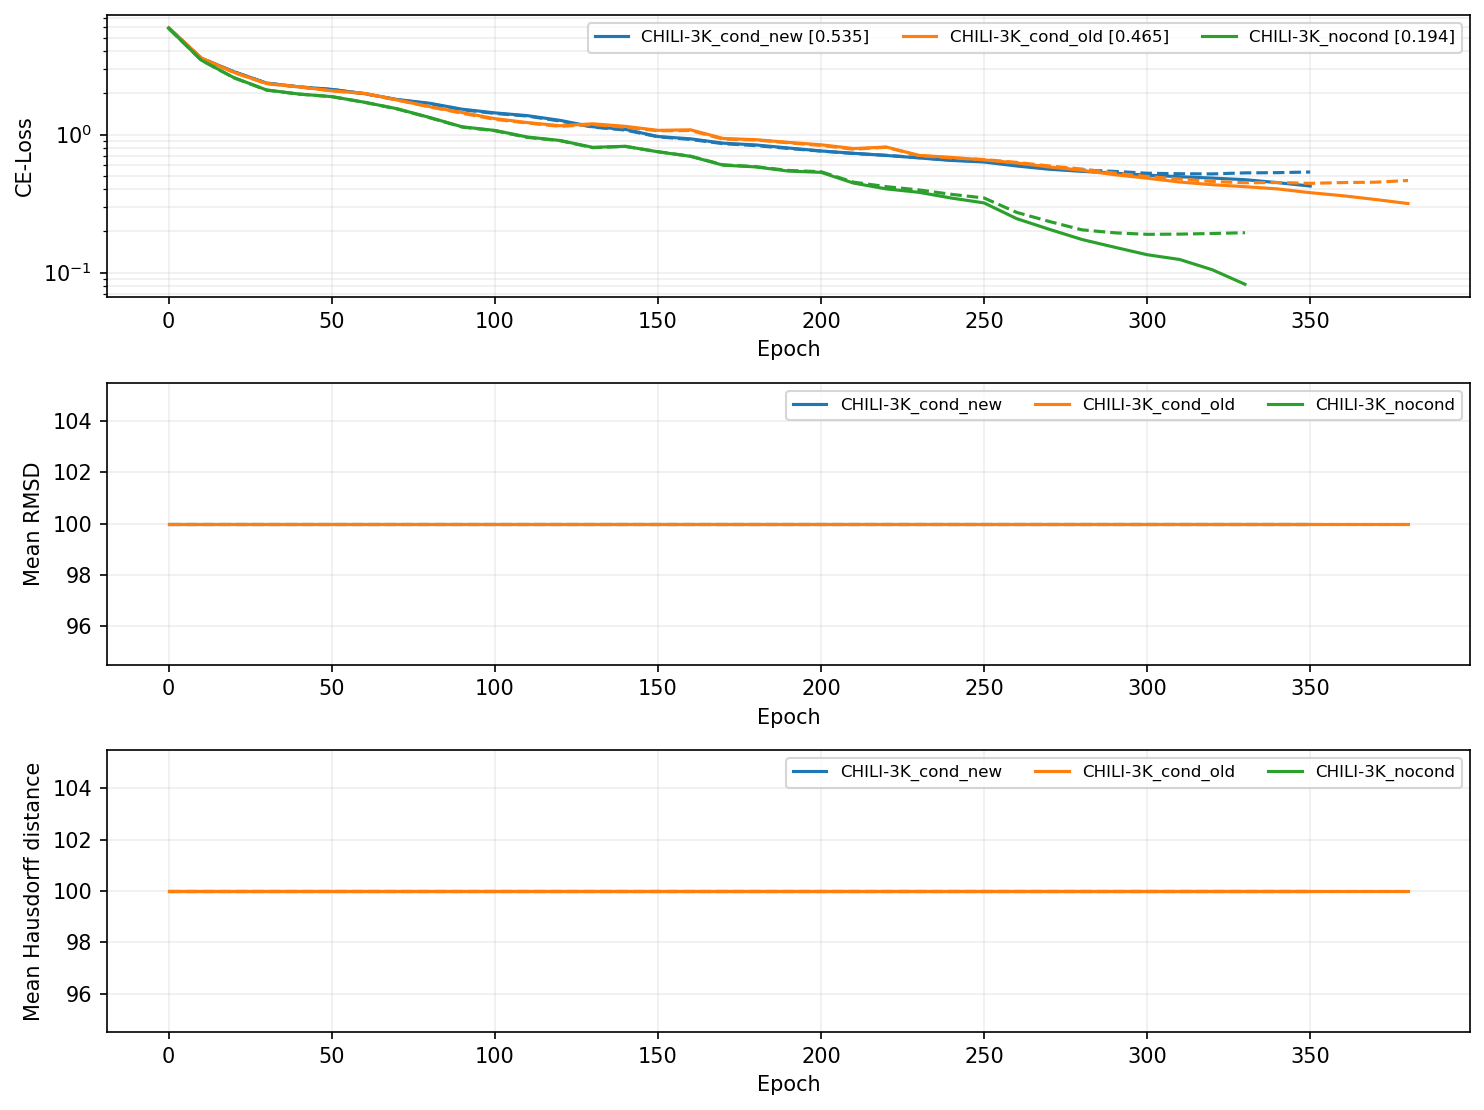

In [2]:
plot_curves(
    [
        'CHILI-3K_cond_new/ckpt.pt',
        'CHILI-3K_cond_old/ckpt.pt',
        'CHILI-3K_nocond/ckpt.pt'
    ],
    ylog = True,
    xlog = False,
    plot_metrics = True,
)

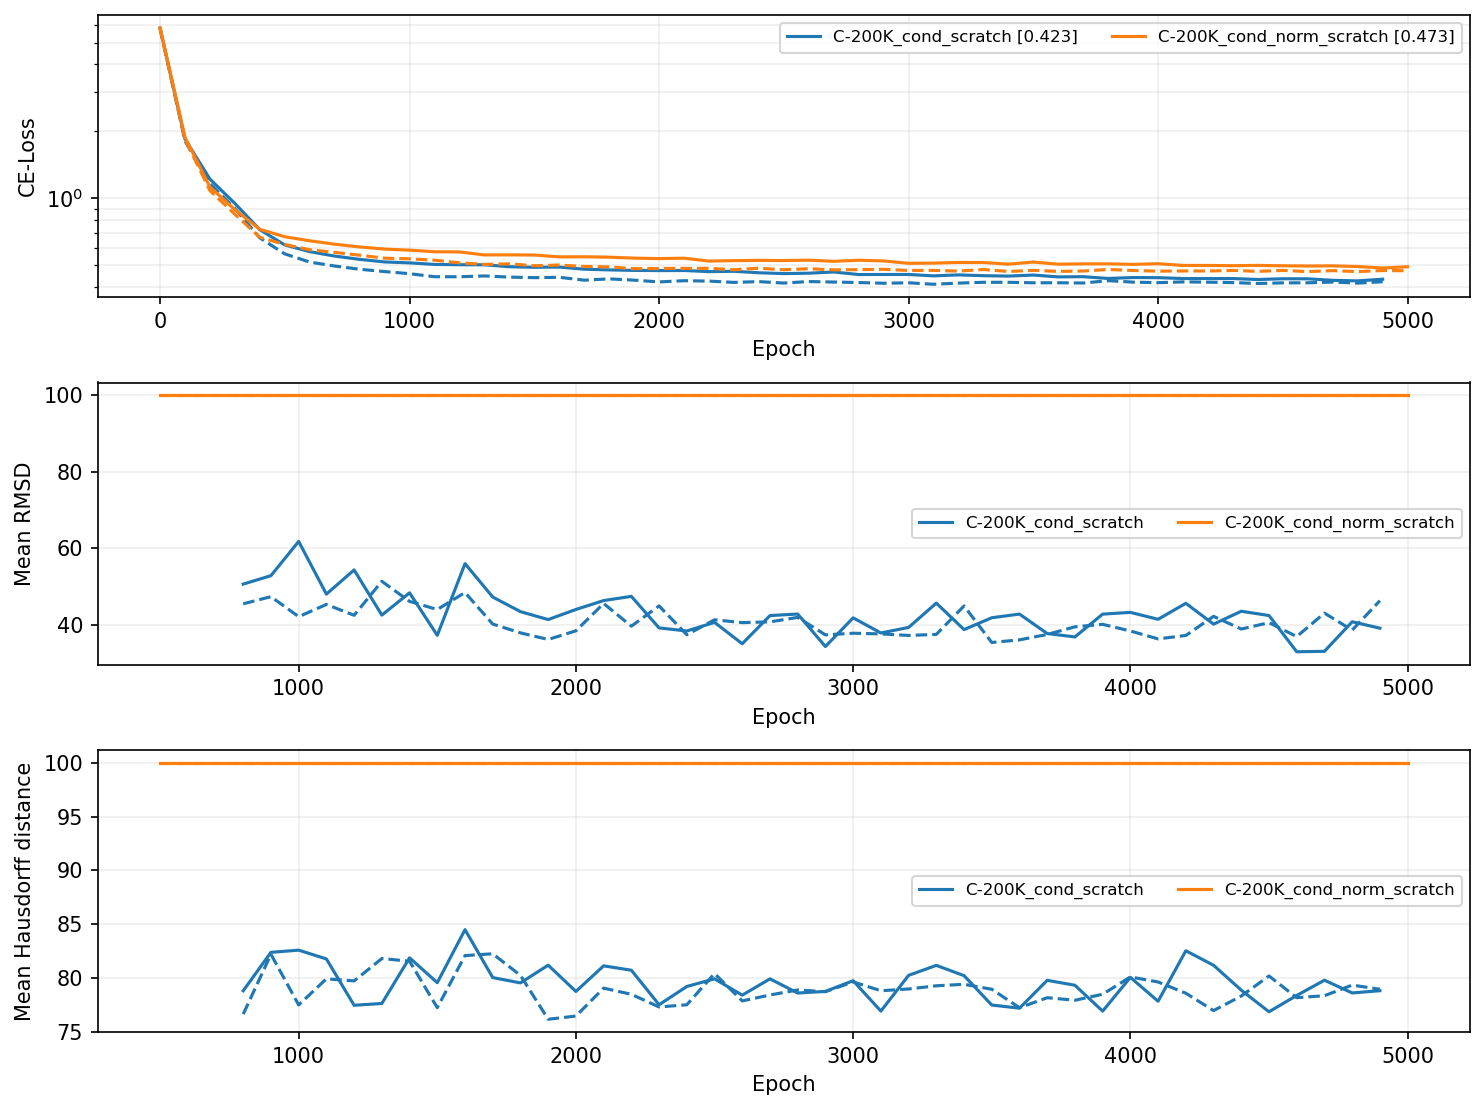

In [3]:
plot_curves(
    [
        'C-200K_cond_scratch/ckpt.pt',
        'C-200K_cond_norm_scratch/ckpt.pt',
    ],
    ylog = True,
    xlog = False,
    plot_metrics = True,
)

In [27]:
batch = torch.randint(100, size=(32, 500))
pattern = torch.tensor([3, 3])

def create_attention_mask(batch, pattern):
    batch_size, seq_len = batch.size()
    mask = torch.zeros(batch_size, seq_len, dtype=torch.float)
    
    for i in range(batch_size):
        # Find the position of the pattern in the sequence
        pos = -1
        for j in range(seq_len - len(pattern) + 1):
            if torch.equal(batch[i, j:j+len(pattern)], pattern):
                pos = j
                break
        
        # Create the mask for this sequence
        if pos != -1:
            mask[i, pos:] = 1.0
    
    return mask

def create_attention_mask(batch, pattern):
    # Convert pattern to tensor and get its length
    pattern_tensor = torch.tensor(pattern, dtype=torch.int64)
    pattern_len = pattern_tensor.size(0)

    # Create a rolling window of the same length as the pattern over the batch
    windows = batch.unfold(1, pattern_len, 1)  # Shape: (batch_size, seq_len - pattern_len + 1, pattern_len)

    # Check where the pattern matches the windows
    matches = (windows == pattern_tensor.unsqueeze(0).unsqueeze(0)).all(dim=2)  # Shape: (batch_size, seq_len - pattern_len + 1)

    # Find the first match for each sequence in the batch
    match_positions = matches.max(dim=1).indices  # Shape: (batch_size,)

    # Create the mask based on match positions
    mask = torch.arange(batch.size(1)).unsqueeze(0) >= match_positions.unsqueeze(1)

    return mask.float()

def create_attention_mask_2(batch, pattern):
    # Convert pattern to tensor and get its length
    pattern_tensor = torch.tensor(pattern, dtype=torch.int64)
    pattern_len = pattern_tensor.size(0)
    batch_size, seq_len = batch.size()

    # Create a rolling window of the same length as the pattern over the batch
    windows = batch.unfold(1, pattern_len, 1)  # Shape: (batch_size, seq_len - pattern_len + 1, pattern_len)

    # Check where the pattern matches the windows
    matches = (windows == pattern_tensor.unsqueeze(0).unsqueeze(0)).all(dim=2)  # Shape: (batch_size, seq_len - pattern_len + 1)

    # Find the first match for each sequence in the batch
    match_positions = matches.float().argmax(dim=1) + pattern_len - 1  # Shape: (batch_size,)

    # Create the mask based on match positions
    mask = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1) >= match_positions.unsqueeze(1)

    return mask.float()

In [28]:
%%timeit
create_attention_mask_slow(batch, pattern)

85.8 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
%%timeit
create_attention_mask(batch, pattern)

160 µs ± 6.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
%%timeit
create_attention_mask_2(batch, pattern)

159 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


### Scripts for generating CIFs

number of total parameters: 25.36M
------------------------------
ZincBlende_SbO
------------------------------
Generation no. 1 :
2.2553,1.0000
2.6042,0.3665
3.6828,0.4182
4.3185,0.3962
4.5105,0.0904
5.2083,0.0636
5.6756,0.1689
data_Nb16Ge16O56
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_atom_type_ionic_radius
Nb 1.6000 1.4500 0.8200
Ge 2.0100 1.2500 0.7700
O 3.4400 0.6000 1.2600
_symmetry_space_group_name_H-M Fd-3m
_cell_length_a 9.6495
_cell_length_b 9.6495
_cell_length_c 9.6495
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 227
_chemical_formula_structural Nb2Ge2O7
_chemical_formula_sum 'Nb16 Ge16 O56'
_cell_volume 898.9601
_cell_formula_units_Z 8
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1 'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Nb Nb0 16 0.1250 0.1250 

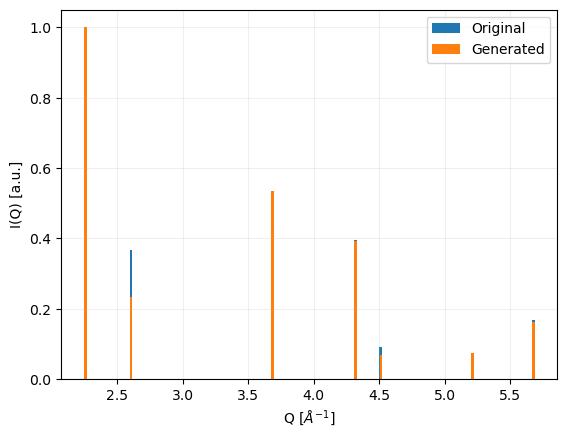


RMSD: 0.06714444491349546
HDD: 0.06714444491349546



In [15]:
import torch
from bin.generate_samples import generate_samples, SampleDefaults, get_data
from crystallm import CIFTokenizer, GPT, GPTConfig
import os

config = SampleDefaults()

config.model_dir = 'C-200K_cond_norm_scratch/'
config.dataset_dir = 'datasets/CHILI-3K_cond/'
config.debug_max = 1
config.cond_window = 500
config.split = 'val'
config.fit_xrd = True
config.top_k = None
config.device = 'cuda'

config.composition = ""
config.spacegroup = ""

config.add_composition = False
config.add_spacegroup = False

config.n_repeats = 1

config.plot_xrd = True

# config.post_process = True
# config.out = "generation_out_test.tar.gz"
# config.individual_cifs = True

generate_samples(config)

In [2]:
config = SampleDefaults()

config.model_dir = 'v1_small_CHILI-3K_lora_r2/'
config.dataset_dir = 'datasets/v1_train_3k_nocond/'
config.debug_max = 1
config.cond_window = 500
config.split = 'train'
config.fit_xrd = True

data, start_indices, cif_start_id, cif_paths = get_data(config)

NameError: name 'SampleDefaults' is not defined

In [6]:
batch_size = 16
cif_paths_batch = torch.tensor([cif_start_id for _ in range(batch_size)]).unsqueeze(-1).to(device='cuda')
cif_paths_batch.shape

torch.Size([16, 1])

In [7]:
tokenizer = CIFTokenizer()

checkpoint = torch.load(config.model_dir + 'ckpt.pt', map_location='cuda')
gptconfig = GPTConfig(**checkpoint["model_args"])
model = GPT(gptconfig)

state_dict = checkpoint["best_model"]

unwanted_prefix = "_orig_mod."
for k, v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model.eval()
model.to('cuda')
model = torch.compile(model)

number of total parameters: 25.39M


In [11]:
%%timeit
model.generate_batched(cif_paths_batch, max_new_tokens=200)

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

32.9 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
for prompt in cif_paths_batch:
    model.generate(prompt.unsqueeze(0), max_new_tokens=200)

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

Generating sequence:   0%|          | 0/200 [00:00<?, ?it/s]

1min 17s ± 225 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


number of total parameters: 12.78M
------------------------------
RheniumTrioxide_CuO3
------------------------------
Generation no. 1 :
1.61,100.0
2.28,29.13
3.22,24.72
3.6,36.02
3.95,11.32
4.56,12.92
4.84,14.85
data_Ni1O1
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
Mo 1.8600
_atom_type_radius
_atom_type_ionic_radius
Ag 1.100
O 1.8600.6000 1.4750


RMSD: NaN
HDD: NaN

